<a href="https://colab.research.google.com/github/jainrasik/NYC-Taxi-Trip-Time-Prediction-Rasik-Jain/blob/main/Team_Notebook_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import warnings
from pylab import rcParams
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Copy of NYC Taxi Data.csv')

In [ ]:
data.shape

(1458644, 11)

There are 1458644 rows and 11 columns.


In [ ]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Integer Data Type

In [ ]:

data.dtypes[data.dtypes=="Int64"]

vendor_id          int64
passenger_count    int64
trip_duration      int64
dtype: object

Summary:

*  passenger_count, trip_duration are number values it's okay. 
*  vendor_id is a unique id for vendor so it converted into category


Float Data Type


In [ ]:
data.dtypes[data.dtypes == "float64"]

pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
dtype: object

pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude are real numbers so its okay as a float

Object Data Type

In [ ]:

data.dtypes[data.dtypes == "object"]

id                    object
pickup_datetime       object
dropoff_datetime      object
store_and_fwd_flag    object
dtype: object

pickup_datetime,dropoff_datetime is a datetime varriable
store_and_fwd_flag belongs to a categorical varriable

Missing Values

Knowing about missing values is important because they indicate how much we don’t know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow

In [ ]:

np.sum(data.isnull())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


Reformatting features & Checking consistency

There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features.

Also, one important thing is never to take assumptions without backing it with data. Here, as you can see the trip duration can also be calculated pick up and drop off datetime. We will check whether the given duration is consistent with the calculated trip duration

In [ ]:
data['trip_duration'].describe()/3600

count    405.178889
mean       0.266526
std        1.454842
min        0.000278
25%        0.110278
50%        0.183889
75%        0.298611
max      979.522778
Name: trip_duration, dtype: float64

One idea to visualise the trip duration better is to log transform it before prediction

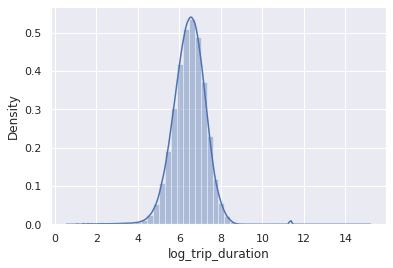

In [ ]:
#Normalisation
data.loc[:,'log_trip_duration']=np.log(data['trip_duration']+1)
sns.distplot(data['log_trip_duration'])

Categorical Feature Analysis:

 Vendor ID

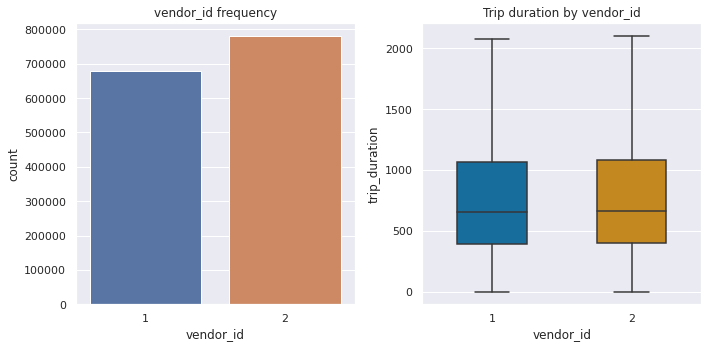

In [ ]:
f, axes = plt.subplots(1,2,figsize=(10, 5), sharex=False, sharey = False)
sns.countplot(x="vendor_id", data=data, ax=axes[0])
axes[0].title.set_text('vendor_id frequency')

sns.boxplot(y='trip_duration', x='vendor_id', 
                 data=data, 
                 width=0.5,
                 palette="colorblind",
                 showfliers=False,
                 ax=axes[1])
axes[1].title.set_text('Trip duration by vendor_id')
plt.tight_layout()
plt.show()

Two unique vendors
Vendor id 2 has more trips than vendor id 1

Text(0.5, 1.0, 'Trip duration by vendor_id')

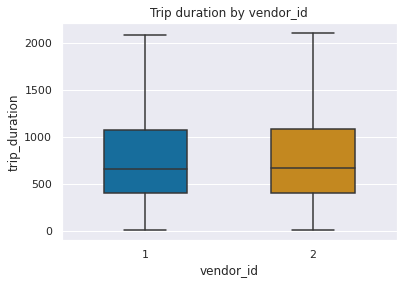

In [ ]:

#we have some major outliers that make the boxes flat, so remove them
sns.boxplot(y='trip_duration', x='vendor_id', 
                 data=data, 
                 width=0.5,
                 palette="colorblind",
                 showfliers=False)
plt.title('Trip duration by vendor_id')

 Store and Forward Flag

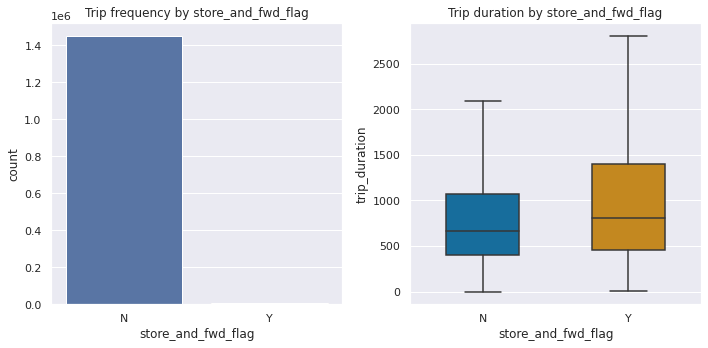

In [ ]:
f, axes = plt.subplots(1,2,figsize=(10, 5), sharex=False, sharey = False)
sns.countplot(x="store_and_fwd_flag", data=data, ax=axes[0])
axes[0].title.set_text('Trip frequency by store_and_fwd_flag')

sns.boxplot(y='trip_duration', x='store_and_fwd_flag', 
                 data=data, 
                 width=0.5,
                 palette="colorblind",
                 showfliers=False,
                 ax=axes[1])
axes[1].title.set_text('Trip duration by store_and_fwd_flag')
plt.tight_layout()
plt.show()

In [ ]:
data.store_and_fwd_flag = data.store_and_fwd_flag.map({"Y":1, "N":0})

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,6.077642


It seems that overall trip frequency is lower with vehicle records needing to stored during a trip. Overall the trip duration is higher when vehicle records have to be stored when vehicle records needing to be stored during a trip.

The main reason there is server disconnection with the vehicle seems to be that there is because longer distances outside server range are traveled, hence the longer trip duration and relative rarity of such trips compared to server connected trips.

We thus wouldn't be directly crediting trip duration increase to the variable flg, and consider it redundant

In [ ]:
#Numerical Varriables
data.select_dtypes(include=['int64','float64',"Int64"]).dtypes

vendor_id               int64
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag      int64
trip_duration           int64
log_trip_duration     float64
dtype: object

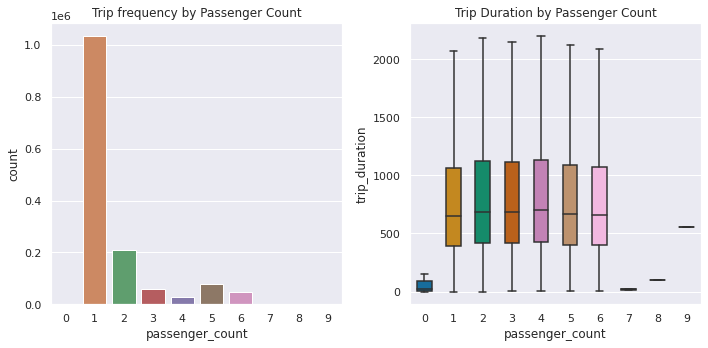

In [ ]:
f, axes = plt.subplots(1,2,figsize=(10, 5), sharex=False, sharey = False)
sns.countplot(x="passenger_count", data=data, ax=axes[0])
axes[0].title.set_text('Trip frequency by Passenger Count')

sns.boxplot(y='trip_duration', x='passenger_count', 
                 data=data, 
                 width=0.5,
                 palette="colorblind",
                 showfliers=False,
                 ax=axes[1])
axes[1].title.set_text('Trip Duration by Passenger Count')
plt.tight_layout()
plt.show()

KeyError: ignored

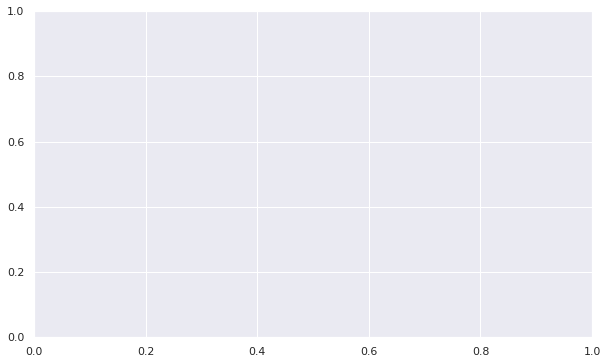

In [ ]:
# Datetime features
plt.figure(figsize=(22, 6))

# Passenger Count
plt.subplot(121)
sns.countplot(data['pickup_day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of trips')

# vendor_id
plt.subplot(122)
sns.countplot(data['pickup_hour'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of trips')

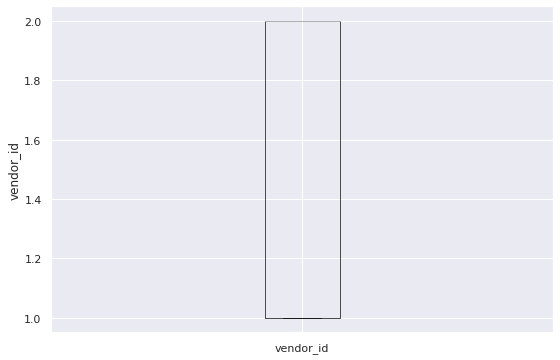

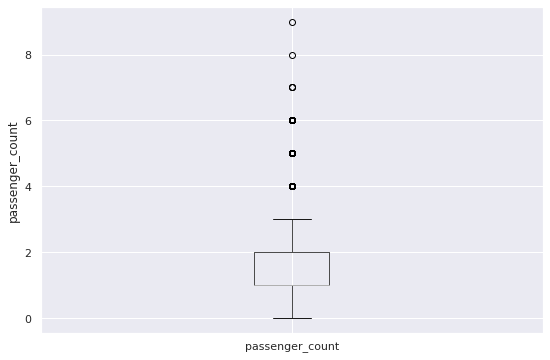

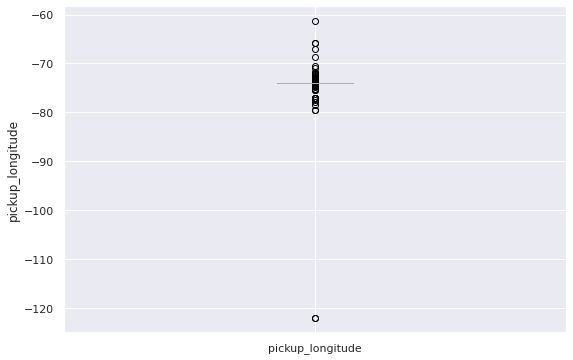

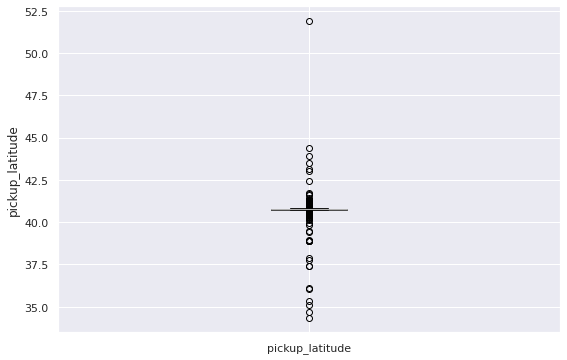

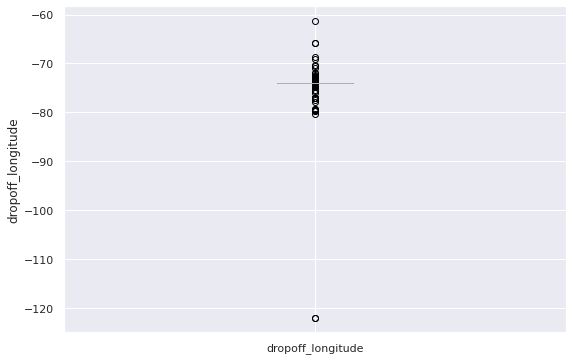

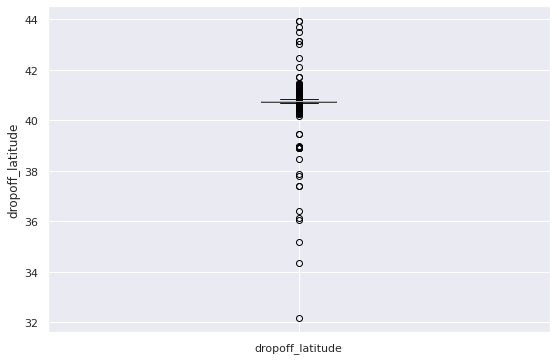

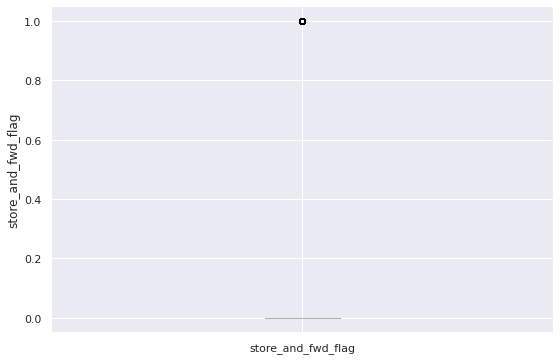

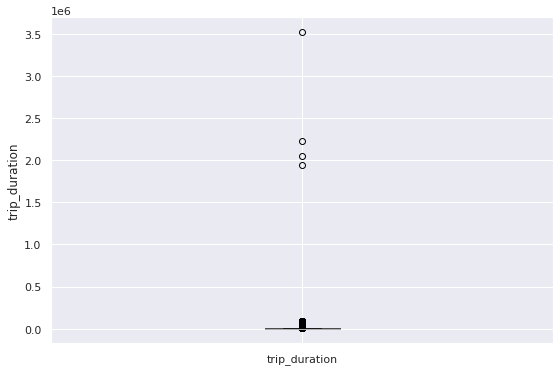

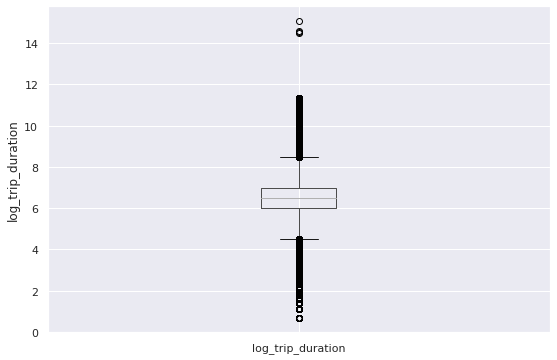

In [ ]:
 #plot a boxplot for the label by each numerical feature  
for col in data.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  data.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.show()

Okay so what we know now :

Vendor ID has no outlier.
In passenger count 4 and more passengers are being treated as outliers.
pickup_longitude and pickup_latitude has outliers as well.
dropoff_longitude and dropoff_latitude has outliers too.
Our target variable trip_duration has alot of outliers

Text(0.5, 1.0, 'Dropoff')

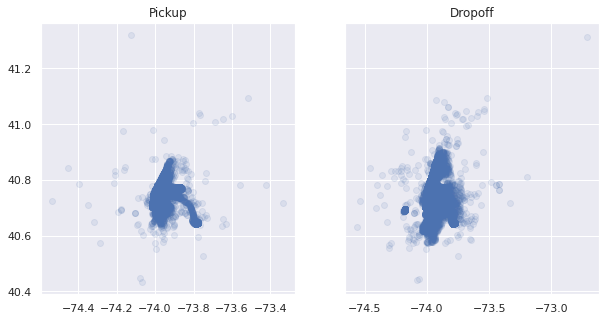

In [ ]:
#plot to see the differences - minimal, but there is some change
n = 100000 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(data.pickup_longitude[:n], 
            data.pickup_latitude[:n],
            alpha = 0.1)
ax1.set_title('Pickup')
ax2.scatter(data.dropoff_longitude[:n], 
            data.dropoff_latitude[:n],
            alpha = 0.1)
ax2.set_title('Dropoff')

In [ ]:
data['pickup_day']=data['pickup_datetime'].dt.day_name()
data['dropoff_day']=data['dropoff_datetime'].dt.day_name()
data.head()

AttributeError: ignored

In [ ]:
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=data,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=data,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')
plt.tight_layout()

In [ ]:
bins=np.array([0,1800,3600,5400,7200,90000])
data['duration_time']=pd.cut(data.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

In [ ]:
import datetime
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
data['pickup_timezone']=df['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
data['dropoff_timezone']=df['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

In [ ]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
sns.countplot(x='pickup_timezone',data=data,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=data,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.show()

In [ ]:
def distance(lat1, lon1, lat2, lon2):
  p = 0.017453292519943295 # pi/180
  a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1- np.cos((lon2 - lon1) * p)) /2
  return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [ ]:
data['distance']= distance(data.pickup_latitude, data.pickup_longitude, data.dropoff_latitude, data.dropoff_longitude)
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,6.122493,0.931138
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6.498282,1.121890
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,7.661527,3.967516
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,6.063785,0.923046
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,6.077642,0.738555


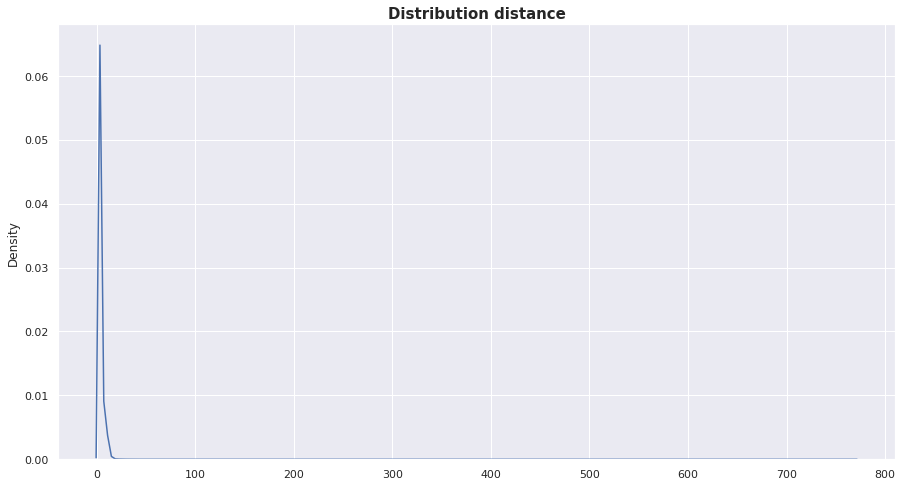

In [ ]:
plt.figure(figsize=(15,8))
sns.kdeplot(data['distance'].values).set_title("Distribution distance",fontsize=15,fontweight='bold');

In [ ]:
data['distance'].describe()

count    1.458644e+06
mean     2.138054e+00
std      2.669745e+00
min      0.000000e+00
25%      7.654278e-01
50%      1.300976e+00
75%      2.408023e+00
max      7.710649e+02
Name: distance, dtype: float64

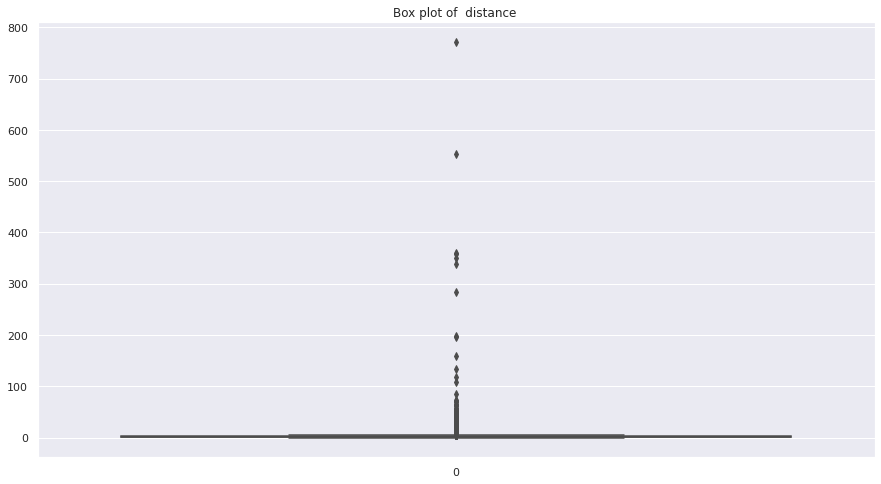

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  distance ")
ax = sns.boxplot(data=data['distance'], orient="v")

In [ ]:
percentile_q1 = np.percentile(data['distance'],25)
print(percentile_q1)
percentile_q2 = np.percentile(data['distance'],50)
print(percentile_q2)
percentile_q3 = np.percentile(data['distance'],75)
print(percentile_q3)

0.7654277645609626
1.3009755270638668
2.408023062337178


In [ ]:
iqr=percentile_q3 - percentile_q1
lower_limit_outlier=percentile_q1-1.5*iqr
upper_limit_outlier=percentile_q3+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier)
print("Upper limit for outlier  :",upper_limit_outlier)

lower limit for outlier  : -1.6984651821033607
Upper limit for outlier  : 4.8719160090015015


In [ ]:
data=data[data['distance']>lower_limit_outlier]
data=data[data['distance']<upper_limit_outlier]
data.shape

(1317971, 13)

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Box plot of  trip_duration ")
ax = sns.boxplot(data=data['trip_duration'], orient="v")

In [ ]:
percentile_q1_trip_duration = np.percentile(df['trip_duration'],25)
print(percentile_q1_trip_duration)
percentile_q2_trip_duration = np.percentile(df['trip_duration'],50)
print(percentile_q2_trip_duration)
percentile_q3_trip_duration = np.percentile(df['trip_duration'],75)
print(percentile_q3_trip_duration)

In [ ]:
iqr=percentile_q3_trip_duration - percentile_q1_trip_duration
lower_limit_outlier_trip_duration=percentile_q1_trip_duration-1.5*iqr
upper_limit_outlier_trip_duration=percentile_q3_trip_duration+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier_trip_duration)
print("Upper limit for outlier  :",upper_limit_outlier_trip_duration)

In [ ]:
data=data[data['trip_duration']>0]
data=data[data['trip_duration']<upper_limit_outlier_trip_duration]
data.shape

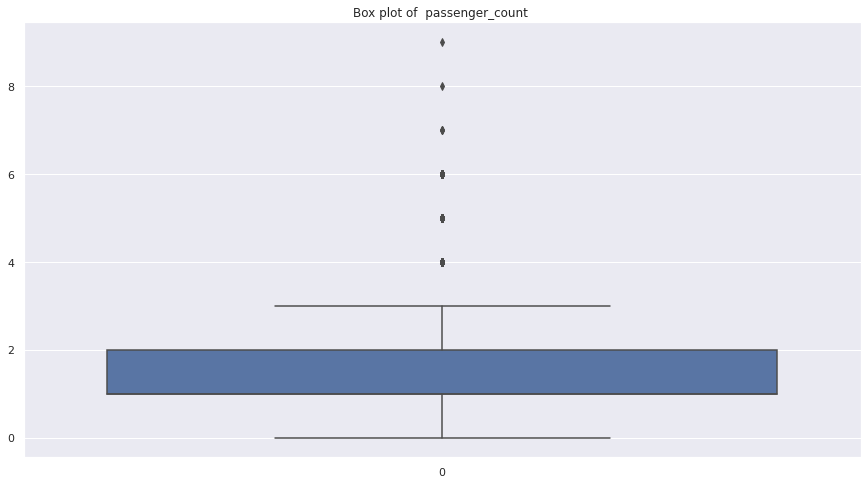

In [ ]:

plt.figure(figsize=(15,8))
plt.title("Box plot of  passenger_count ")
ax = sns.boxplot(data=data['passenger_count'], orient="v")

In [ ]:
percentile_q1_passenger_count = np.percentile(data['passenger_count'],25)
print(percentile_q1_passenger_count)
percentile_q2_passenger_count = np.percentile(data['passenger_count'],50)
print(percentile_q2_passenger_count)
percentile_q3_passenger_count = np.percentile(data['passenger_count'],75)
print(percentile_q3_passenger_count)

1.0
1.0
2.0


In [ ]:
iqr=percentile_q3_passenger_count - percentile_q1_passenger_count
lower_limit_outlier_passenger_count=percentile_q1_passenger_count-1.5*iqr
upper_limit_outlier_passenger_count=percentile_q3_passenger_count+1.5*iqr
print("lower limit for outlier  :",lower_limit_outlier_passenger_count)
print("Upper limit for outlier  :",upper_limit_outlier_passenger_count)

lower limit for outlier  : -0.5
Upper limit for outlier  : 3.5


In [ ]:
data=data[data['passenger_count']>0]
data=data[data['passenger_count']<upper_limit_outlier_passenger_count]
data.shape

(1178606, 13)

In [ ]:

data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")

In [ ]:
data['Day']=data['pickup_datetime'].dt.day_name()

In [ ]:
data["year"] = data["pickup_datetime"].apply(lambda x: x.year)
data["month"] = data["pickup_datetime"].apply(lambda x: x.month)
data["day_num"] =data["pickup_datetime"].apply(lambda x: x.day)
data["hour"] = data["pickup_datetime"].apply(lambda x: x.hour)
data["minute"] = data["pickup_datetime"].apply(lambda x: x.minute)

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,distance,Day,year,month,day_num,hour,minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,6.122493,0.931138,Monday,2016,3,14,17,24
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6.498282,1.121890,Sunday,2016,6,12,0,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,7.661527,3.967516,Tuesday,2016,1,19,11,35
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,6.063785,0.923046,Wednesday,2016,4,6,19,32
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,6.077642,0.738555,Saturday,2016,3,26,13,30


In [ ]:

data['trip_duration_hour']=data['trip_duration']/3600
data['log_distance']=np.log(data.distance)
data['log_trip_duration']=np.log(data.trip_duration_hour)

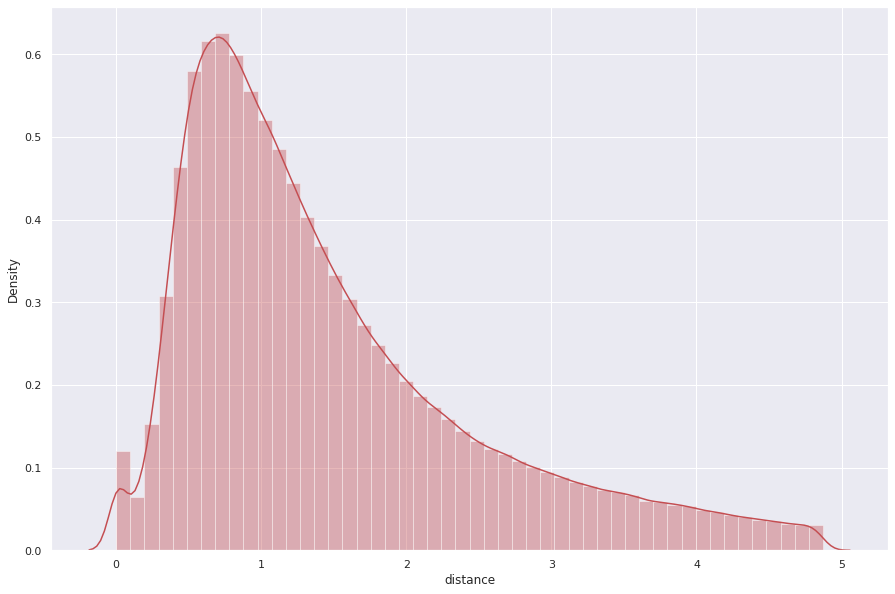

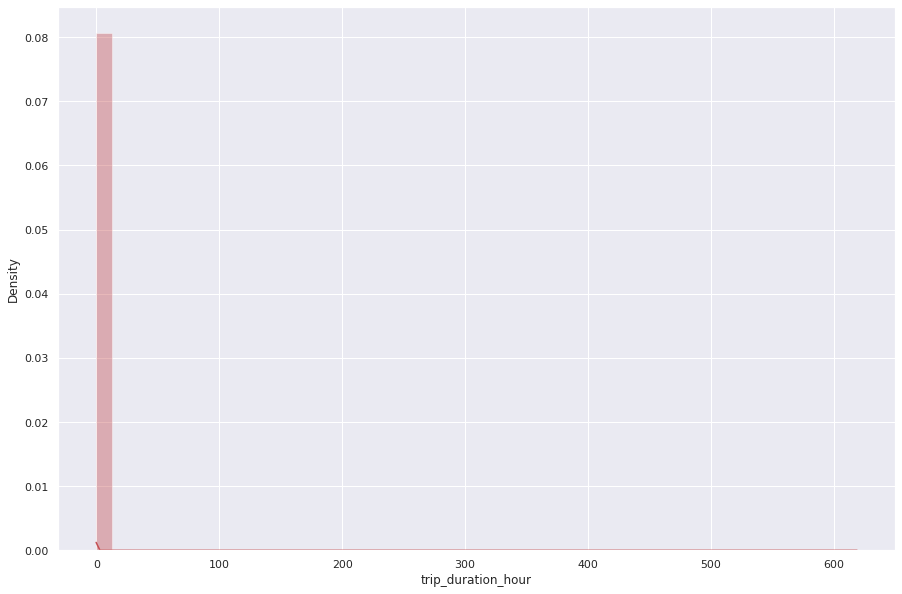

In [ ]:
sample=['distance','trip_duration_hour']
for i in sample:
  plt.figure(figsize=(15,10))
  sns.distplot(data[i],color="R")

In [ ]:
data= pd.get_dummies(data, columns=["store_and_fwd_flag", "Day"], prefix=["store_and_fwd_flag",'Day'])

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,distance,year,month,day_num,hour,minute,trip_duration_hour,log_distance,store_and_fwd_flag_0,store_and_fwd_flag_1,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,-2.068392,0.931138,2016,3,14,17,24,0.126389,-0.071348,1,0,0,1,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,-1.691914,1.121890,2016,6,12,0,43,0.184167,0.115015,1,0,0,0,0,1,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,-0.527633,3.967516,2016,1,19,11,35,0.590000,1.378140,1,0,0,0,0,0,0,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,-2.127232,0.923046,2016,4,6,19,32,0.119167,-0.080076,1,0,0,0,0,0,0,0,1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,-2.113343,0.738555,2016,3,26,13,30,0.120833,-0.303060,1,0,0,0,1,0,0,0,0


In [ ]:
features=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_1','store_and_fwd_flag_0','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday']

In [ ]:
newdata=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_1','store_and_fwd_flag_0','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday','trip_duration_hour']
trip_data=data[newdata]

In [ ]:
from scipy.stats import zscore
#Train test split
X = data[features].apply(zscore)[:100000]
y=data['trip_duration_hour'][:100000]

In [ ]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

In [ ]:

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(80000, 19) (80000,)
(20000, 19) (20000,)


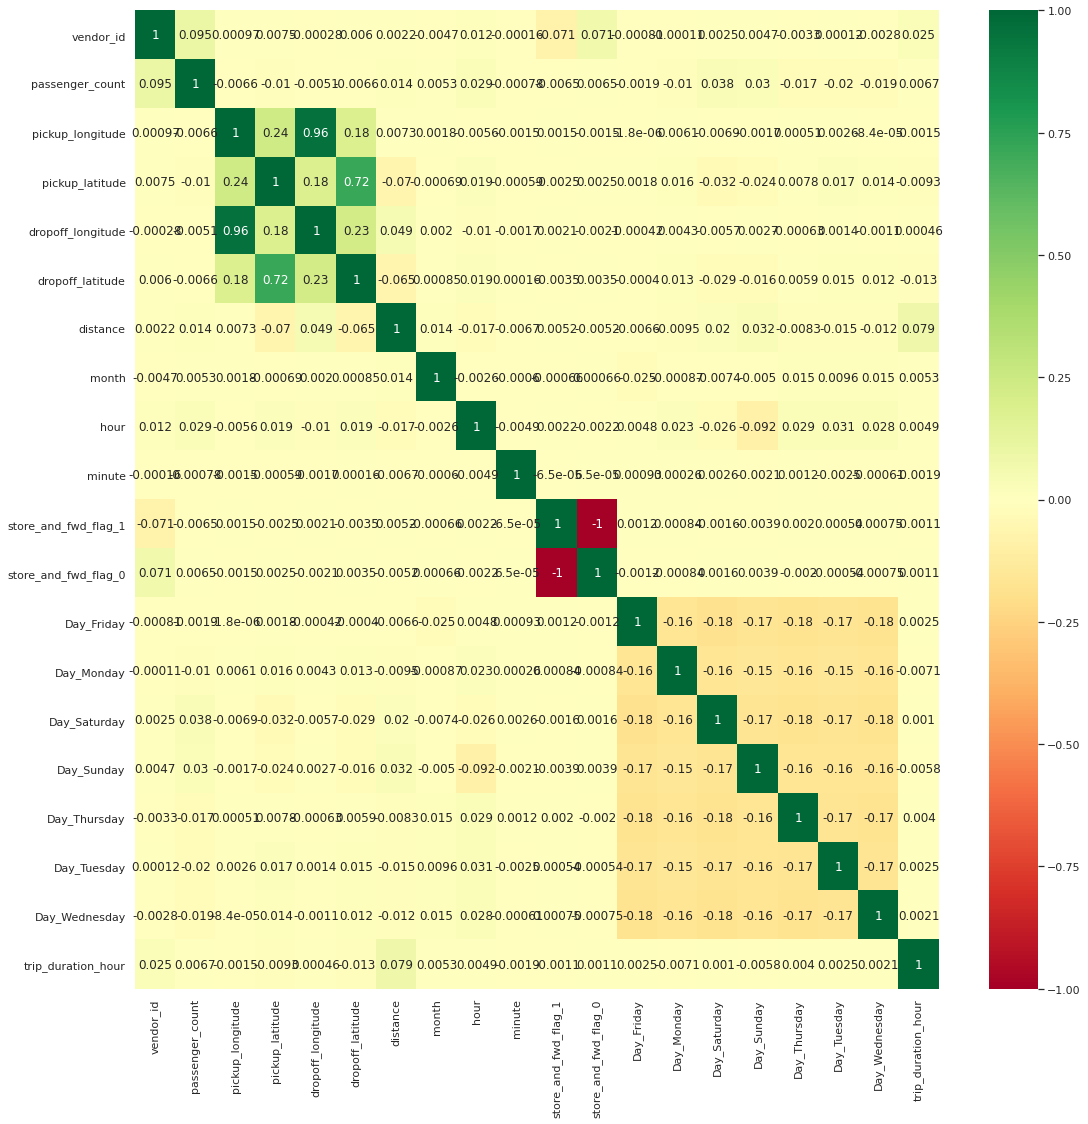

In [ ]:
plt.figure(figsize = (18,18))
sns.heatmap(trip_data.corr(), annot = True, cmap = "RdYlGn")

plt.show()

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

In [ ]:

reg.score(X_train, y_train)

0.012303162999249826

In [ ]:
y_pred_train = reg.predict(X_train)

In [ ]:
y_pred_test = reg.predict(X_test)

In [ ]:
#Train set metrics
Ltr_MSE  = mean_squared_error((y_train), (y_pred_train))
print("MSE :" , Ltr_MSE)

Ltr_RMSE = np.sqrt(Ltr_MSE)

print("RMSE :" ,Ltr_RMSE)

Ltr_r2 = r2_score((y_train), (y_pred_train))
print("R2 :" ,Ltr_r2)
Ltr_ar2 = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Adjusted R2 : ",Ltr_ar2)

MSE : 0.6382110739544956
RMSE : 0.7988811388150904
R2 : 0.012303162999249828
Adjusted R2 :  0.012068526341297736


In [ ]:
#Test set metrics
Lte_MSE  = mean_squared_error((y_test), (y_pred_test))
print("MSE :" , Lte_MSE)

Lte_RMSE = np.sqrt(Lte_MSE)
print("RMSE :" ,Lte_RMSE)

Lte_r2 = r2_score((y_test), (y_pred_test))
print("R2 :" ,Lte_r2)
Lte_ar2 = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Lte_ar2)

MSE : 0.5591980446412852
RMSE : 0.7477954564192572
R2 : 0.0176775951716589
Adjusted R2 :  0.01674345474664707


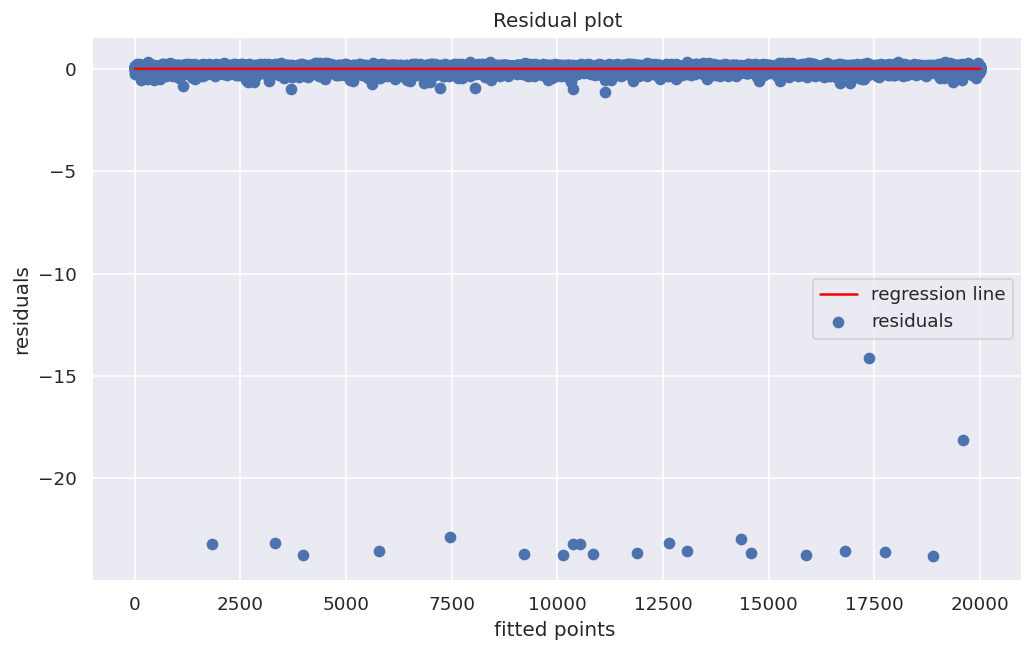

In [ ]:

#Heteroskedasticity
residuals=y_pred_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

DECISION TREEE

In [ ]:
# Maximum depth of trees
max_depth = [4,6,8,10]

# Minimum number of samples required to split a node
min_samples_split = [10,20,30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [10,16,20]

# HYperparameter Grid
param_dt = {
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV


In [ ]:

dt_model = DecisionTreeRegressor()

# Grid search
dt_grid = GridSearchCV(estimator=dt_model,
                       param_grid = param_dt,
                       cv = 5, verbose=2, scoring='r2')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [10, 16, 20],
                         'min_samples_split

In [ ]:
dt_grid.best_score_

0.007364473836381391

In [ ]:

dt_grid.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
dt_optimal_model =dt_grid.best_estimator_

In [ ]:
y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

In [ ]:
y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

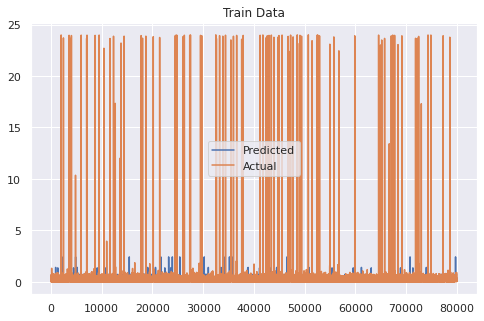

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_dt_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:

MSE  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.6359328083272435
Train RMSE : 0.7974539537347868
Train R2 : 0.01582901180651275
Train Adjusted R2 :  0.015595212747052


In [ ]:
MSE  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.5620477501948146
Test RMSE : 0.7496984395040546
Test R2 : 0.01267162342475947
Test Adjusted R2 :  0.01173272256615443


In [ ]:

X_train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'month', 'hour',
       'minute', 'store_and_fwd_flag_1', 'store_and_fwd_flag_0', 'Day_Friday',
       'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [ ]:
dt_optimal_model.feature_importances_

array([0.06748005, 0.        , 0.        , 0.01671909, 0.        ,
       0.11398312, 0.77353595, 0.        , 0.02828179, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [ ]:
importances = dt_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [ ]:
importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)
importance_df

In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

,Feature,Feature Importance
6,distance,0.77
5,dropoff_latitude,0.11
0,vendor_id,0.07
8,hour,0.03
3,pickup_latitude,0.02
12,Day_Friday,0.00
17,Day_Tuesday,0.00
16,Day_Thursday,0.00
15,Day_Sunday,0.00
14,Day_Saturday,0.00


[Text(0, 0, 'distance'),
 Text(0, 0, 'dropoff_latitude'),
 Text(0, 0, 'vendor_id'),
 Text(0, 0, 'hour'),
 Text(0, 0, 'pickup_latitude'),
 Text(0, 0, 'Day_Friday'),
 Text(0, 0, 'Day_Tuesday'),
 Text(0, 0, 'Day_Thursday'),
 Text(0, 0, 'Day_Sunday'),
 Text(0, 0, 'Day_Saturday'),
 Text(0, 0, 'Day_Monday'),
 Text(0, 0, 'minute'),
 Text(0, 0, 'store_and_fwd_flag_0'),
 Text(0, 0, 'store_and_fwd_flag_1'),
 Text(0, 0, 'passenger_count'),
 Text(0, 0, 'month'),
 Text(0, 0, 'dropoff_longitude'),
 Text(0, 0, 'pickup_longitude'),
 Text(0, 0, 'Day_Wednesday')]

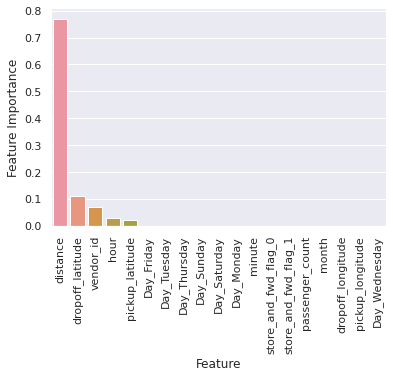

In [ ]:
chart = sns.barplot(x="Feature", y="Feature Importance", data=importance_df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

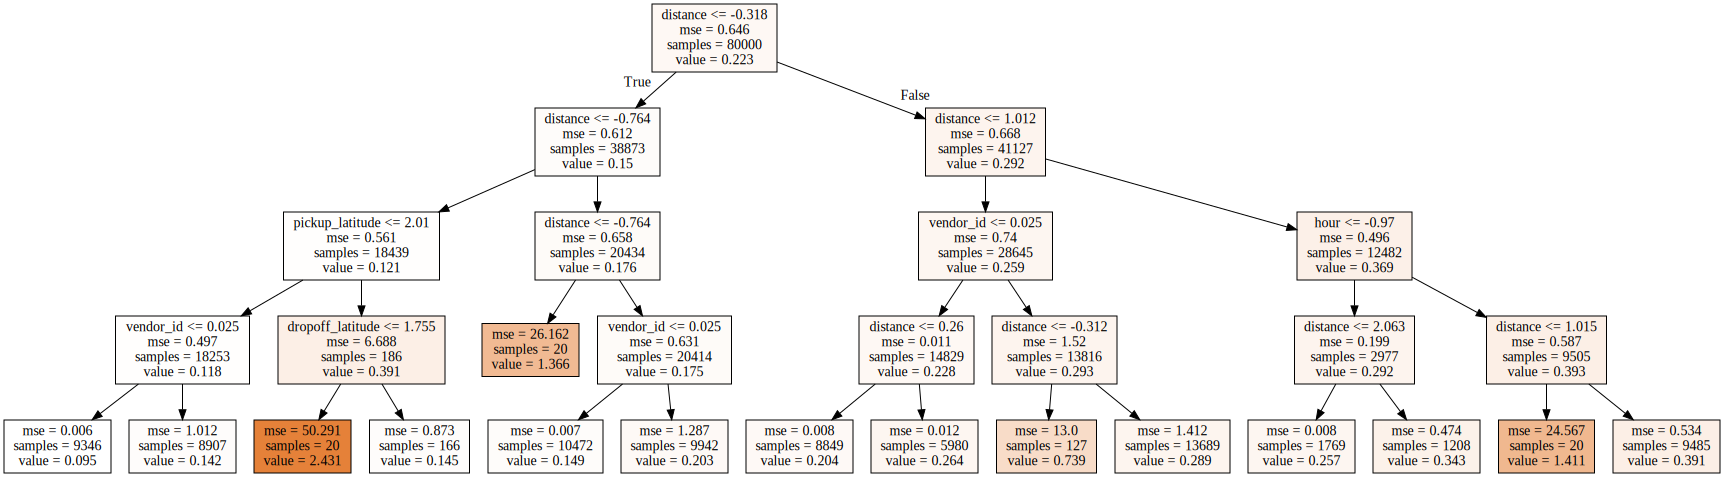

In [ ]:
graph = Source(tree.export_graphviz(dt_optimal_model, out_file=None,feature_names=X_train.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

XGBOOST

In [ ]:
# Number of trees
n_estimators = [50,100,120]

# Maximum depth of trees
max_depth = [5,7,9]
min_samples_split = [40,50]
#learning_rate=[0.1,0.3,0.5]

# HYperparameter Grid
param_xgb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
             'min_samples_split':min_samples_split
              }

In [ ]:
# Create an instance of the  XGBRegressor
import xgboost as xgb
xgb_model = xgb.XGBRegressor()

# Grid search
xgb_grid = GridSearchCV(estimator=xgb_model,param_grid = param_xgb,cv = 3, verbose=2,scoring="r2")

xgb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[05:03:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   3.7s
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[05:03:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   3.6s
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[05:03:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   3.6s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[05:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=100, total=   6.9s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[05:04:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=100, total=   6.9s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[05:04:11] WARNING: /workspace/src/objective/

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  8.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 7, 9], 'min_samples_split': [40, 50],
                         'n_estimators': [50, 100, 1

In [ ]:
xgb_grid.best_score_

-0.009198767465481872

In [ ]:
xgb_grid.best_params_

{'max_depth': 5, 'min_samples_split': 40, 'n_estimators': 50}

In [ ]:

xgb_optimal_model =xgb_grid.best_estimator_

In [ ]:
y_pred_xgb_test=xgb_optimal_model.predict(X_test)
y_pred_xgb_train=xgb_optimal_model.predict(X_train)

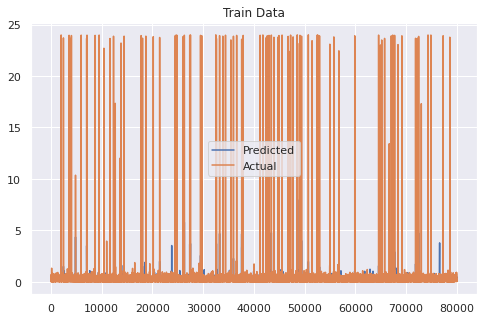

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_xgb_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_train, y_pred_xgb_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_xgb_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score((y_train), (y_pred_xgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.5104866941560622
Train RMSE : 0.7144835156643309
Train R2 : 0.2099696891425895
Train Adjusted R2 :  0.20978201002398134


In [ ]:

MSE  = mean_squared_error(y_test, y_pred_xgb_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_xgb_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_xgb_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.5725220721234918
Test RMSE : 0.7566518830502518
Test R2 : -0.005728228299551885
Test Adjusted R2 :  -0.006684626514651404


In [ ]:
X_train.columns

In [ ]:
xgb_optimal_model.feature_importances_

In [ ]:
importances = xgb_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [ ]:
importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)
importance_df

In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)

In [ ]:
chart = sns.barplot(x="Feature", y="Feature Importance", data=importance_df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

GRADIENT BOOSTING

In [ ]:
# Number of trees
n_estimators = [100,120]

# Maximum depth of trees
max_depth = [5,8,10]

# Minimum number of samples required to split a node
min_samples_split = [50,80]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]


# HYperparameter Grid
param_gb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [ ]:
# Create an instance of the  GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_model=GradientBoostingRegressor()

# Grid search
gb_grid = GridSearchCV(estimator=gb_model,
                       param_grid = param_gb,
                       cv = 3, verbose=2, scoring='r2')

gb_grid.fit(X_train,y_train)